<a href="https://colab.research.google.com/github/alirezash97/Advanced-AI-Course/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# !mkdir mnist

mkdir: cannot create directory ‘mnist’: File exists


In [ ]:
# !pip install ray
# !pip install tensorboardX

In [ ]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import tensorboardX

In [ ]:
def load_data(data_dir="./data"):


  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5), (0.5))])

  trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)


  testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
  
  return trainset, testset  


In [ ]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                           shuffle=True, num_workers=2)

# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

In [ ]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# print(images.shape)
# print(labels.shape)

# # show images
# imshow(torchvision.utils.make_grid(images))
# # print labels
# print('    '.join('%5s' % labels[j] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F 

class Net(nn.Module):
  
  def __init__(self, l1=256, l2=128):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 6)
    self.fc1 = nn.Linear(16 * 4 * 4, l1)
    self.fc2 = nn.Linear(l1, l2)
    self.fc3 = nn.Linear(l2, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Network = Net()


In [ ]:
def train_mnist(config, checkpoint_dir='/content/mnist', data_dir=None):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [ ]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")
    load_data(data_dir)
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(5, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(4, 9)),
        "lr": tune.loguniform(1e-5, 1e-1),
        "batch_size": tune.choice([8, 16, 32])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_mnist, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    torch.save(best_trained_model.state_dict(), '/content/mnist/best_trained_model.pth')
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=10, max_num_epochs=10, gpus_per_trial=0)

2021-01-31 13:46:33,988	WARNING experiment.py:285 -- No name detected on trainable. Using DEFAULT.
2021-01-31 13:46:33,989	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.


== Status ==
Memory usage on this node: 3.6/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-01-31_13-46-34
Number of trials: 1/10 (1 RUNNING)
+---------------------+----------+-------+--------------+------+------+-------------+
| Trial name          | status   | loc   |   batch_size |   l1 |   l2 |          lr |
|---------------------+----------+-------+--------------+------+------+-------------|
| DEFAULT_bb314_00000 | RUNNING  |       |           32 |  256 |  128 | 0.000899926 |
+---------------------+----------+-------+--------------+------+------+-------------+




0it [00:00, ?it/s]


(pid=5806) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 59%|█████▊    | 5816320/9912422 [00:00<00:03, 1043125.24it/s]
9920512it [00:01, 8984594.59it/s]                             


(pid=5806) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=5806) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


32768it [00:00, 129118.92it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=5806) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=5806) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 26%|██▋       | 434176/1648877 [00:00<00:04, 285924.19it/s]
1654784it [00:00, 2617526.45it/s]                           
0it [00:00, ?it/s]


(pid=5806) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=5806) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 49602.48it/s]            
(pid=5806) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=5806)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=5806) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=5806) Processing...
(pid=5806) Done!
Result for DEFAULT_bb314_00000:
  accuracy: 0.8854166666666666
  date: 2021-01-31_13-46-58
  done: false
  experiment_id: fac4e29c3d074ae9874a82fa98c43078
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 0.36338458651304245
  node_ip: 172.28.0.2
  pid: 5806
  should_checkpoint: true
  time_since_restore: 22.810088634490967
  time_this_iter_s: 22.810088634490967
  time_total_s: 22.810088634490967
  timestamp: 1612100818
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00000
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.36338458651304245
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-01-31_13-46-3

0it [00:00, ?it/s]


(pid=6473) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 57%|█████▋    | 5685248/9912422 [00:00<00:04, 1039784.77it/s]
9920512it [00:01, 9337631.35it/s]                             


(pid=6473) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=6473) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


32768it [00:00, 134462.75it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=6473) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6473) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 13%|█▎        | 212992/1648877 [00:00<00:03, 379622.90it/s]
1654784it [00:00, 2592451.67it/s]                           
0it [00:00, ?it/s]


(pid=6473) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=6473) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 48750.98it/s]            
(pid=6473) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=6473)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=6473) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6473) Processing...
(pid=6473) Done!
(pid=6473) [1,  2000] loss: 2.342
(pid=6473) [1,  4000] loss: 1.160
(pid=6473) [1,  6000] loss: 0.773
Result for DEFAULT_bb314_00001:
  accuracy: 0.09391666666666666
  date: 2021-01-31_13-50-31
  done: true
  experiment_id: 3cf1ad055fcc43479890a5aa78b4d91f
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 2.3186806173324586
  node_ip: 172.28.0.2
  pid: 6473
  should_checkpoint: true
  time_since_restore: 38.617504835128784
  time_this_iter_s: 38.617504835128784
  time_total_s: 38.617504835128784
  timestamp: 1612101031
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00001
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: -0.0897116613437732 | Iter 4.000: -0.10838675576572616 | Iter 2.000: -0.18674556809167067 | Iter 1.000: -1.3410326019227505
Resources requested: 

0it [00:00, ?it/s]


(pid=6562) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 77%|███████▋  | 7602176/9912422 [00:00<00:02, 1045589.39it/s]
9920512it [00:00, 10072003.74it/s]                            


(pid=6562) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]


(pid=6562) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 134911.65it/s]           
0it [00:00, ?it/s]


(pid=6562) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6562) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 26%|██▋       | 434176/1648877 [00:00<00:04, 269186.04it/s]
1654784it [00:00, 2618201.83it/s]                           
0it [00:00, ?it/s]


(pid=6562) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=6562) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 45659.14it/s]            
(pid=6562) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=6562)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=6562) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6562) Processing...
(pid=6562) Done!
(pid=6562) [1,  2000] loss: 2.299
(pid=6562) [1,  4000] loss: 1.146
(pid=6562) [1,  6000] loss: 0.762
Result for DEFAULT_bb314_00002:
  accuracy: 0.19925
  date: 2021-01-31_13-51-12
  done: true
  experiment_id: 1712ea9bf4bc459c9f069baff7cc885f
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 2.2803328717549642
  node_ip: 172.28.0.2
  pid: 6562
  should_checkpoint: true
  time_since_restore: 39.461854696273804
  time_this_iter_s: 39.461854696273804
  time_total_s: 39.461854696273804
  timestamp: 1612101072
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00002
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.0897116613437732 | Iter 4.000: -0.10838675576572616 | Iter 2.000: -0.18674556809167067 | Iter 1.000: -2.2803328717549642
Resources requested: 2/2 CPUs, 0/

0it [00:00, ?it/s]
  0%|          | 0/9912422 [00:00<?, ?it/s]


(pid=6652) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 58%|█████▊    | 5742592/9912422 [00:00<00:04, 1036713.41it/s]
9920512it [00:01, 9511897.44it/s]                             


(pid=6652) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]
32768it [00:00, 291040.55it/s]           
0it [00:00, ?it/s]


(pid=6652) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz
(pid=6652) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6652) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 53%|█████▎    | 876544/1648877 [00:00<00:01, 528198.74it/s]
1654784it [00:00, 2609850.28it/s]                           
0it [00:00, ?it/s]


(pid=6652) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=6652) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 49337.38it/s]            
(pid=6652) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=6652)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=6652) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6652) Processing...
(pid=6652) Done!
(pid=6652) [1,  2000] loss: 2.286
Result for DEFAULT_bb314_00003:
  accuracy: 0.3935
  date: 2021-01-31_13-51-40
  done: false
  experiment_id: c419a7e832624c8eb010258f73a53968
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 2.1615316751797993
  node_ip: 172.28.0.2
  pid: 6652
  should_checkpoint: true
  time_since_restore: 26.712560176849365
  time_this_iter_s: 26.712560176849365
  time_total_s: 26.712560176849365
  timestamp: 1612101100
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00003
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.0897116613437732 | Iter 4.000: -0.10838675576572616 | Iter 2.000: -0.18674556809167067 | Iter 1.000: -2.2209322734673815
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_t

0it [00:00, ?it/s]


(pid=6808) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 59%|█████▊    | 5799936/9912422 [00:00<00:03, 1049560.24it/s]
9920512it [00:01, 9289301.64it/s]                             


(pid=6808) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=6808) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


32768it [00:00, 124330.42it/s]           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]


(pid=6808) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6808) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 13%|█▎        | 212992/1648877 [00:00<00:03, 381199.80it/s]
1654784it [00:00, 2600129.90it/s]                           
0it [00:00, ?it/s]


(pid=6808) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=6808) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 46499.82it/s]            
(pid=6808) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=6808)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=6808) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6808) Processing...
(pid=6808) Done!
(pid=6808) [1,  2000] loss: 2.302
Result for DEFAULT_bb314_00004:
  accuracy: 0.22591666666666665
  date: 2021-01-31_13-52-34
  done: true
  experiment_id: 20a927a5f60d4d0b9007aea0f6da657f
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 2.281290429751078
  node_ip: 172.28.0.2
  pid: 6808
  should_checkpoint: true
  time_since_restore: 27.87723135948181
  time_this_iter_s: 27.87723135948181
  time_total_s: 27.87723135948181
  timestamp: 1612101154
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00004
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 8.000: -0.0897116613437732 | Iter 4.000: -0.10838675576572616 | Iter 2.000: -0.34529714386413496 | Iter 1.000: -2.2803328717549642
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accel

0it [00:00, ?it/s]


(pid=6904) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 77%|███████▋  | 7667712/9912422 [00:00<00:02, 1054639.11it/s]
9920512it [00:00, 10250627.19it/s]                            


(pid=6904) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=6904) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


32768it [00:00, 130145.35it/s]           
0it [00:00, ?it/s]


(pid=6904) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6904) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 13%|█▎        | 212992/1648877 [00:00<00:03, 381312.32it/s]
1654784it [00:00, 2522454.46it/s]                           
0it [00:00, ?it/s]


(pid=6904) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=6904) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 47261.39it/s]            
(pid=6904) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=6904)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=6904) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6904) Processing...
(pid=6904) Done!
Result for DEFAULT_bb314_00005:
  accuracy: 0.11333333333333333
  date: 2021-01-31_13-52-57
  done: true
  experiment_id: 8657acefac414da283f4e934e13da9fe
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 2.3091776084899904
  node_ip: 172.28.0.2
  pid: 6904
  should_checkpoint: true
  time_since_restore: 21.476381540298462
  time_this_iter_s: 21.476381540298462
  time_total_s: 21.476381540298462
  timestamp: 1612101177
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00005
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.0897116613437732 | Iter 4.000: -0.10838675576572616 | Iter 2.000: -0.34529714386413496 | Iter 1.000: -2.280811650753021
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: 

0it [00:00, ?it/s]
  0%|          | 0/9912422 [00:00<?, ?it/s]


(pid=6998) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to ./data/MNIST/raw/train-images-idx3-ubyte.gz


 58%|█████▊    | 5701632/9912422 [00:00<00:03, 1054987.71it/s]
9920512it [00:01, 9463830.65it/s]                             


(pid=6998) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]


(pid=6998) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 125178.82it/s]           
0it [00:00, ?it/s]


(pid=6998) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6998) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 26%|██▋       | 434176/1648877 [00:00<00:04, 285433.97it/s]
1654784it [00:00, 2580454.73it/s]                           
0it [00:00, ?it/s]


(pid=6998) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=6998) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


8192it [00:00, 45951.27it/s]            
(pid=6998) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=6998)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=6998) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=6998) Processing...
(pid=6998) Done!
(pid=6998) [1,  2000] loss: 1.661
(pid=6998) [1,  4000] loss: 0.169
(pid=6998) [1,  6000] loss: 0.065
Result for DEFAULT_bb314_00006:
  accuracy: 0.9410833333333334
  date: 2021-01-31_13-53-35
  done: false
  experiment_id: 619505a8f1fc456fb5b48ebd4db0385f
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 0.18863880212636044
  node_ip: 172.28.0.2
  pid: 6998
  should_checkpoint: true
  time_since_restore: 36.66552686691284
  time_this_iter_s: 36.66552686691284
  time_total_s: 36.66552686691284
  timestamp: 1612101215
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00006
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 8.000: -0.0897116613437732 | Iter 4.000: -0.10838675576572616 | Iter 2.000: -0.34529714386413496 | Iter 1.000: -2.2803328717549642
Resources requested: 2/

0it [00:00, ?it/s]
 89%|████████▉ | 8839168/9912422 [00:01<00:00, 1454695.91it/s]
9920512it [00:01, 9423946.03it/s]                             


(pid=7698) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=7698) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=7698) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=7698) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


32768it [00:00, 125679.96it/s]           
0it [00:00, ?it/s]
 13%|█▎        | 212992/1648877 [00:00<00:03, 379144.83it/s]


(pid=7698) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=7698) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz


1654784it [00:00, 2629320.45it/s]                           
0it [00:00, ?it/s]


(pid=7698) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=7698) Processing...
(pid=7698) Done!


8192it [00:00, 47313.78it/s]            
(pid=7698) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=7698)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=7698) [1,  2000] loss: 0.270
Result for DEFAULT_bb314_00007:
  accuracy: 0.9745
  date: 2021-01-31_13-59-00
  done: false
  experiment_id: 75ed5b05c53e4d98a149458075aaeab7
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 0.08472147036863802
  node_ip: 172.28.0.2
  pid: 7698
  should_checkpoint: true
  time_since_restore: 26.576237440109253
  time_this_iter_s: 26.576237440109253
  time_total_s: 26.576237440109253
  timestamp: 1612101540
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00007
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 8.000: -0.07091882415525075 | Iter 4.000: -0.08854407716981949 | Iter 2.000: -0.18674556809167067 | Iter 1.000: -2.2209322734673815
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-01-31_13-46-34
Number of trials: 9/10 (1 PENDING, 1 RUNNING, 7 TERMINAT

0it [00:00, ?it/s]
 77%|███████▋  | 7675904/9912422 [00:00<00:02, 1051500.32it/s]


(pid=8366) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


9920512it [00:00, 10022046.56it/s]                            


(pid=8366) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 128790.06it/s]           
0it [00:00, ?it/s]


(pid=8366) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=8366) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


 13%|█▎        | 212992/1648877 [00:00<00:03, 373944.70it/s]
1654784it [00:00, 2603212.58it/s]                           
0it [00:00, ?it/s]


(pid=8366) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=8366) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=8366) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=8366) Processing...
(pid=8366) Done!


8192it [00:00, 48953.79it/s]            
(pid=8366) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=8366)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=8366) [1,  2000] loss: 0.423
(pid=8366) [1,  4000] loss: 0.064
(pid=8366) [1,  6000] loss: 0.038
Result for DEFAULT_bb314_00008:
  accuracy: 0.9765833333333334
  date: 2021-01-31_14-03-11
  done: false
  experiment_id: bf288d884ca049e4b7d05ffa7bcaabe1
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 0.07932847607161027
  node_ip: 172.28.0.2
  pid: 8366
  should_checkpoint: true
  time_since_restore: 36.54379963874817
  time_this_iter_s: 36.54379963874817
  time_total_s: 36.54379963874817
  timestamp: 1612101791
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00008
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 8.000: -0.058029713310248594 | Iter 4.000: -0.06870139857391283 | Iter 2.000: -0.15438309785776072 | Iter 1.000: -2.1615316751797993
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAUL

0it [00:00, ?it/s]
 58%|█████▊    | 5767168/9912422 [00:00<00:03, 1044083.15it/s]


(pid=8910) Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


9920512it [00:01, 8998094.01it/s]                             


(pid=8910) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to ./data/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


(pid=8910) Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=8910) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


32768it [00:00, 125972.90it/s]           
0it [00:00, ?it/s]
 26%|██▋       | 434176/1648877 [00:00<00:04, 283984.40it/s]
1654784it [00:00, 2617191.85it/s]                           
0it [00:00, ?it/s]


(pid=8910) Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
(pid=8910) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
(pid=8910) Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
(pid=8910) Processing...
(pid=8910) Done!


8192it [00:00, 47717.09it/s]            
(pid=8910) /usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=8910)   return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


(pid=8910) [1,  2000] loss: 0.391
(pid=8910) [1,  4000] loss: 0.062
(pid=8910) [1,  6000] loss: 0.034
Result for DEFAULT_bb314_00009:
  accuracy: 0.976
  date: 2021-01-31_14-07-46
  done: false
  experiment_id: 806709a2500c4df98a13fc2fbac2249f
  hostname: e5256f0d2afd
  iterations_since_restore: 1
  loss: 0.09669549158099024
  node_ip: 172.28.0.2
  pid: 8910
  should_checkpoint: true
  time_since_restore: 37.19880247116089
  time_this_iter_s: 37.19880247116089
  time_total_s: 37.19880247116089
  timestamp: 1612102066
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: bb314_00009
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 8.000: -0.07015560009690873 | Iter 4.000: -0.06575626885644958 | Iter 2.000: -0.1220206276238508 | Iter 1.000: -1.262458130846421
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-01-31_13-

2021-01-31 14:09:28,529	INFO tune.py:448 -- Total run time: 1374.54 seconds (1374.51 seconds for the tuning loop).


Result for DEFAULT_bb314_00009:
  accuracy: 0.9824166666666667
  date: 2021-01-31_14-09-28
  done: true
  experiment_id: 806709a2500c4df98a13fc2fbac2249f
  hostname: e5256f0d2afd
  iterations_since_restore: 4
  loss: 0.06577379287740041
  node_ip: 172.28.0.2
  pid: 8910
  should_checkpoint: true
  time_since_restore: 138.89089679718018
  time_this_iter_s: 33.43943524360657
  time_total_s: 138.89089679718018
  timestamp: 1612102168
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: bb314_00009
  
== Status ==
Memory usage on this node: 3.8/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 8.000: -0.07015560009690873 | Iter 4.000: -0.06577379287740041 | Iter 2.000: -0.10913785539126063 | Iter 1.000: -1.262458130846421
Resources requested: 2/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2021-01-31_13-46-34
Number of trials: 10/10 (1 RUNNING, 9 TERMINATED)
+---------------------+-------

In [48]:
selected_model = torch.load('/content/mnist/best_trained_model.pth')

import torch.nn as nn
import torch.nn.functional as F 

class Net(nn.Module):
  
  def __init__(self, l1=128, l2=128):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 8, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(8, 16, 6)
    self.fc1 = nn.Linear(16 * 4 * 4, l1)
    self.fc2 = nn.Linear(l1, l2)
    self.fc3 = nn.Linear(l2, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 4 * 4)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

Network = Net()

torch.Size([4, 1, 28, 28])
torch.Size([4])


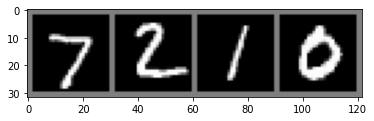

tensor(7)    tensor(2)    tensor(1)    tensor(0)
tensor([-10.8191,   1.6636,   2.4512,   1.9567,   3.1343,  -6.2229, -12.5967,
         26.7180,  -7.0877,   1.2668], grad_fn=<SelectBackward>)    tensor([-0.6255, -1.1039, 23.6166, -2.1254, -2.2714, -7.9334,  0.1757,  3.0199,
        -7.3991, -8.9134], grad_fn=<SelectBackward>)    tensor([-6.0135, 16.5910,  2.1729, -6.0225,  1.1906, -5.1513,  0.0735,  2.4927,
        -2.1769, -4.6850], grad_fn=<SelectBackward>)    tensor([21.2110, -5.7609, -6.2538, -4.2260, -2.6596, -3.3602,  4.0311,  0.8784,
        -3.0712, -2.2024], grad_fn=<SelectBackward>)


In [49]:
import matplotlib.pyplot as plt


my_trainset, my_testset = load_data()

my_testloader = torch.utils.data.DataLoader(my_testset, batch_size=4,
                                         shuffle=False, num_workers=2)


Network.load_state_dict(selected_model)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(my_testloader)
images, labels = dataiter.next()
outputs = Network(images)
print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('    '.join('%5s' % labels[j] for j in range(4)))
print('    '.join('%5s' % outputs[j] for j in range(4)))

In [ ]:
from sklearn.metrics import precision_score, recall_score

correct = 0
# precision = []
# recall = []
final_predicted = []
final_labels = []
total = 0
with torch.no_grad():
    i = 0
    for data in my_testloader:
        i += 1
        images, labels = data
        outputs = Network(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        final_predicted = np.concatenate((final_predicted, np.array(predicted)))
        final_labels= np.concatenate((final_labels, np.array(labels)))

precision = precision_score(final_labels, final_predicted, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')
recall = recall_score(final_labels, final_predicted, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], average='micro')

print('Accuracy of the network on the %d test images: %d %%' % (i*4, 100 * correct / total))

print('Precision of the network on the %d test images: %f %%' % (i*4, precision))

print('Recall of the network on the %d test images: %f %%' % (i*4, recall))

Accuracy of the network on the 10000 test images: 98 %
Precision of the network on the 10000 test images: 0.986500 %
Recall of the network on the 10000 test images: 0.986500 %
